<a href="https://colab.research.google.com/github/Carancho25/Challenge-2-Telecom/blob/main/RevModeloRegrecionLogisticaHKT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ucimlrepo

In [ ]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import warnings
import xgboost as xgb
import plotly.express as px

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_validate

from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
warnings.filterwarnings('ignore')

import joblib
import pickle

In [ ]:
dfIranian = pd.read_csv("https://archive.ics.uci.edu/static/public/563/data.csv")

dfEsp = dfIranian.rename(columns={
    'Call  Failure': 'Fallos_Llamadas',
    'Complains' : 'Quejas',
    'Subscription  Length': 'Meses_permanencia',
    'Charge  Amount': 'Cargo ',
    'Seconds of Use': 'Total_segundos',
    'Frequency of use': 'Total_llamadas',
    'Frequency of SMS': 'Total_mensajes',
    'Distinct Called Numbers': 'Llamadas_numeros_distintos',
    'Age Group': 'Grupo_edades',
    'Tariff Plan': 'Plan_tarifa',
    'Status': 'Estado_clientes',
    'Age': 'Edad',
    'Customer Value': 'Valor_cliente',
    'Churn': 'Abandono'})

In [ ]:
corrMatrix = dfEsp.corr(numeric_only=True)
dfFilt = pd.DataFrame(corrMatrix[['Abandono']])*100
dfFilt

,Abandono
Fallos_Llamadas,-0.898737
Quejas,53.205296
Meses_permanencia,-3.258789
Cargo,-20.230536
Total_segundos,-29.893454
Total_llamadas,-30.333734
Total_mensajes,-22.075364
Llamadas_numeros_distintos,-27.886687
Grupo_edades,-1.455019
Plan_tarifa,-10.585294


In [ ]:
vl = 35
df2 = (dfFilt[(dfFilt['Abandono'] < vl) & (dfFilt['Abandono'] > -vl) & (dfFilt['Abandono']!=-1) & (dfFilt['Abandono']!=1)]).T
colFilt = df2.columns.tolist()
dfEnt = dfEsp[['Abandono']+colFilt]

In [ ]:
dfEnt.columns

Index(['Abandono', 'Fallos_Llamadas', 'Meses_permanencia', 'Cargo ',
       'Total_segundos', 'Total_llamadas', 'Total_mensajes',
       'Llamadas_numeros_distintos', 'Grupo_edades', 'Plan_tarifa', 'Edad',
       'Valor_cliente'],
      dtype='object')

In [ ]:
# Calcular la matriz de correlación completa (sin filtrar)
corrMatrix = dfEnt.corr(numeric_only=True)

# Crear el heatmap con todas las correlaciones
fig = px.imshow(
    corrMatrix,  # <-- Usar la matriz completa
    text_auto=True,  # Muestra los valores numéricos
    color_continuous_scale='RdBu',  # Escala de colores (rojo=negativo, azul=positivo)
    zmin=-1,  # Rango mínimo de correlación
    zmax=1,   # Rango máximo de correlación
    title='Matriz de Correlación'
)

# Ajustes de diseño
fig.update_layout(
    width=800,  # Ancho del gráfico
    height=800,  # Alto del gráfico (puedes ajustarlo)
    xaxis_title='Variables',
    yaxis_title='Variables',
    xaxis=dict(tickangle=90)  # Rotar etiquetas del eje X para mejor legibilidad
)

fig.show()

In [ ]:
dfEnt.columns

Index(['Abandono', 'Fallos_Llamadas', 'Meses_permanencia', 'Cargo ',
       'Total_segundos', 'Total_llamadas', 'Total_mensajes',
       'Llamadas_numeros_distintos', 'Grupo_edades', 'Plan_tarifa', 'Edad',
       'Valor_cliente'],
      dtype='object')

In [ ]:
#dfEnt = dfEnt[['Abandono','Plan_tarifa','Cargo ','Fallos_Llamadas','Grupo_edades']]

In [ ]:
x = dfEnt.drop(columns=['Abandono'])
y = dfEnt['Abandono']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

#Balanceo de Clases disminuye los datos
from imblearn import under_sampling
undersampling = RandomUnderSampler(random_state=42, sampling_strategy='auto')
xTrainBal, yTrainBal = undersampling.fit_resample(x_train, y_train)
print(yTrainBal.value_counts())
print(yTrainBal.value_counts(normalize=True)*100)

##### validación cruzada con sensibilidad
def intervaloConfianza(resultados):
    promedio = resultados['test_score'].mean()
    desviStd = resultados['test_score'].std()
    return f'El intervalo de confianza es: [{promedio-2*desviStd},{min(promedio+2*desviStd,1)}]'

#random_state=42, solver='liblinear', max_iter=1000, class_weight=None, C=10, penalty='l1'

mdRgLnUnder = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000, class_weight=None, C=10, penalty='l1')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
kf = KFold(n_splits=5, shuffle=True, random_state=5)
pipeline = imbpipeline([('undersamplig', SMOTE()),('Regresión logistica', mdRgLnUnder)])
cvResultados = cross_validate(pipeline, x, y,cv=skf,scoring='recall')
print(f'Undersampling {intervaloConfianza(cvResultados)}')

mdRgLnUnder.fit(xTrainBal, yTrainBal)

Abandono
0    333
1    333
Name: count, dtype: int64
Abandono
0    50.0
1    50.0
Name: proportion, dtype: float64
Undersampling El intervalo de confianza es: [0.740810336648041,0.9036341077964036]


LogisticRegression(C=10, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

              precision    recall  f1-score   support

           0       0.95      0.74      0.83       783
           1       0.39      0.80      0.52       162

    accuracy                           0.75       945
   macro avg       0.67      0.77      0.68       945
weighted avg       0.85      0.75      0.78       945



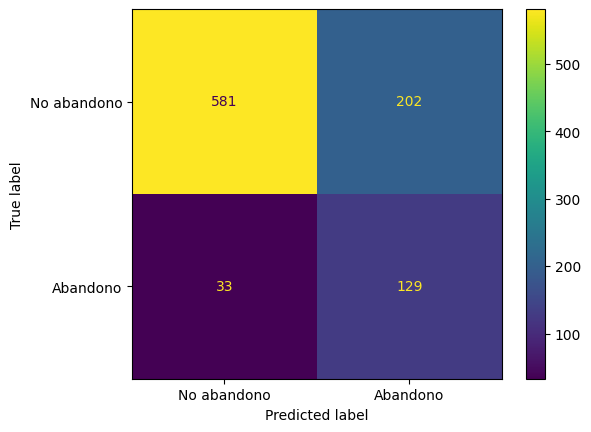

In [ ]:
yPrevisto = mdRgLnUnder.predict(x_test)
print(classification_report(y_test,yPrevisto))
ConfusionMatrixDisplay.from_predictions(y_test,yPrevisto, display_labels=['No abandono','Abandono'])
plt.show()

In [ ]:
print(f'La exactitud del modelo con el conjunto de entrenamiento es de: {mdRgLnUnder.score(x_test,y_test)}')

La exactitud del modelo con el conjunto de entrenamiento es de: 0.7513227513227513


In [ ]:
importanciamdRgLnUnder = np.abs(mdRgLnUnder.coef_[0])
caracteImportmdRgLnUnder = pd.DataFrame({'Features': xTrainBal.columns, 'Importancia': importanciamdRgLnUnder * 100}).round(2).sort_values(by='Importancia', ascending=False).reset_index(drop=True)

In [ ]:
varImportmdRgLnUnder = px.histogram(caracteImportmdRgLnUnder, x = 'Features', y='Importancia', text_auto = True)
varImportmdRgLnUnder.update_traces(texttemplate='%{y:.2f}%', textposition='outside')
varImportmdRgLnUnder.update_layout(title='Importancia de variables despues de entrenar modelo de Regresión Logistica con Undersample')
varImportmdRgLnUnder.show()

In [ ]:
print("Por favor, ingrese los siguientes datos del cliente:\n")
print("\n" + "="*50)

datos_usuario = {}

# Solicitar cada campo con ejemplos
campos = [
    ('meses_permanencia', "Meses de permanencia: ", int),
    ('retrasos_pago', "Retrasos en pagos: ", int),
    ('uso_mensual', "Uso de servicios: ", int),
    ('soporte_técnico_si', "Soporte técnico (si/no): ", str),
    ('servicio_internet_no', "Servicio internet (si/no): ", str),
    ('servicio_telefónico_si', "Servicio telefónico (si/no): ", str),
    ('dependientes_si', "Tiene dependientes (si/no): ", str)
]

for campo, mensaje, tipo in campos:
    while True:
        try:
            valor = input(mensaje)
            if tipo == str:
                # Convertir respuestas 'si'/'no' a 1/0
                if valor.lower() in ['si', 'sí', '1', 'yes', 'y']:
                    datos_usuario[campo] = 1
                elif valor.lower() in ['no', '0', 'n']:
                    datos_usuario[campo] = 0
                else:
                    print("Por favor ingrese 'si' o 'no'")
                    continue
            else:
                datos_usuario[campo] = tipo(valor)
            break
        except ValueError:
            print(f"Error: Por favor ingrese un valor válido de tipo {tipo.__name__}")

# Crear un DataFrame con datos del usuario
datos_df = pd.DataFrame([datos_usuario])

# Asegurarse de que las columnas estén en el mismo orden que durante el entrenamiento
columnas_ordenadas = ['meses_permanencia', 'retrasos_pago', 'uso_mensual',
                      'soporte_técnico_si', 'servicio_internet_no',
                      'servicio_telefónico_si', 'dependientes_si']
datos_df = datos_df[columnas_ordenadas]

# Hacer la predicción
try:
    # Predicción de clase (0=no abandono, 1=abandono)
    prediccionClase = mdRgLnUnder.predict(datos_df)[0]

    # Probabilidades para cada clase
    probabilidades = mdRgLnUnder.predict_proba(datos_df)[0]

    # Determinar la etiqueta basada en la predicción
    if prediccionClase == 1:
        prevision = "Va a cancelar"
        probabilidad = probabilidades[1]  # Probabilidad de abandono
    else:
        prevision = "No va a cancelar"
        probabilidad = probabilidades[0]  # Probabilidad de no abandono

    # Crear el diccionario de salida
    resultado = {
        "prevision": prevision,
        "probabilidad": round(float(probabilidad), 4)
    }

    print(f"\nDatos ingresados:")
    for campo, valor in datos_usuario.items():
        print(f"  {campo}: {valor}")

except Exception as e:
    print(f"Error al realizar la predicción: {e}")
    resultado = {
        "prevision": "Error en predicción",
        "probabilidad": 0.0
    }
    print(resultado)

print("\n" + "="*50)
dfResupredit = pd.DataFrame([resultado])
print(dfResupredit)

print("\n" + "="*50)
print("Resultado en formato JSON:")
import json
print(json.dumps(resultado, indent=2))

abandono
0    1318
1    1318
Name: count, dtype: int64
abandono
0    50.0
1    50.0
Name: proportion, dtype: float64
Undersampling El intervalo de confianza es: [0.7168645440488011,0.7716216425291691]
Por favor, ingrese los siguientes datos del cliente:


Meses de permanencia: 15
Retrasos en pagos: 14
Uso de servicios: 3
Soporte técnico (si/no): sin
Por favor ingrese 'si' o 'no'
Soporte técnico (si/no): si
Servicio internet (si/no): si
Servicio telefónico (si/no): si
Tiene dependientes (si/no): si

Datos ingresados:
  meses_permanencia: 15
  retrasos_pago: 14
  uso_mensual: 3
  soporte_técnico_si: 1
  servicio_internet_no: 1
  servicio_telefónico_si: 1
  dependientes_si: 1

          prevision  probabilidad
0  No va a cancelar        0.8779

Resultado en formato JSON:
{
  "prevision": "No va a cancelar",
  "probabilidad": 0.8779
}


**Optimizacion Final**

In [ ]:
# Definimos los datasets definitivos sin las columnas de pago
columnas_pago = [col for col in x_train.columns if 'método_de_pago' in col.lower()]
x_train_final = x_train.drop(columns=columnas_pago)
x_test_final = x_test.drop(columns=columnas_pago)

print(f"Variables actuales para el modelo: {x_train_final.columns.tolist()}")

Variables actuales para el modelo: ['meses_permanencia', 'retrasos_pago', 'uso_mensual', 'soporte_técnico_si', 'servicio_internet_no', 'servicio_telefónico_si', 'dependientes_si']


**Se efectua el re-ajuste para la nueva estructura de datos**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import RandomUnderSampler

# Re-creamos el pipeline
pipeline_final = imbpipeline([
    ('under', RandomUnderSampler(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# Definimos la rejilla de parámetros
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear']
}

# Ejecutamos la búsqueda
grid_rl_final = GridSearchCV(
    estimator=pipeline_final,
    param_grid=param_grid,
    cv=5,
    scoring='recall', # Seguimos priorizando detectar el Churn
    verbose=1
)

grid_rl_final.fit(x_train_final, y_train)

print(f"Mejores parámetros post-ajuste: {grid_rl_final.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros post-ajuste: {'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}


In [ ]:
import pandas as pd

# 1. Definimos al cliente problemático (sin variables de pago)
datos_cliente = pd.DataFrame({
    'meses_permanencia': [15],
    'retrasos_pago': [14],
    'uso_mensual': [4],
    'soporte_técnico_si': [1],
    'servicio_internet_no': [0],
    'servicio_telefónico_si': [0],
    'dependientes_si': [1]
})

# 2. Predecir con el modelo optimizado (grid_rl_final)
prediccion_final = grid_rl_final.predict(datos_cliente)
probabilidades_final = grid_rl_final.predict_proba(datos_cliente)

# 3. Mostrar el veredicto
veredicto = "VA A CANCELAR (Churn)" if prediccion_final[0] == 1 else "NO VA A CANCELAR"
print(f"==================================================")
print(f"RESULTADO TRAS EL RE-AJUSTE")
print(f"Previsión: {veredicto}")
print(f"Probabilidad de que se quede: {probabilidades_final[0][0]:.4f}")
print(f"Probabilidad de que SE VAYA: {probabilidades_final[0][1]:.4f}")
print(f"==================================================")

RESULTADO TRAS EL RE-AJUSTE
Previsión: NO VA A CANCELAR
Probabilidad de que se quede: 0.5184
Probabilidad de que SE VAYA: 0.4816


**Ajuste del umbral de decision **
## Implementación de Umbral Personalizado (Threshold: 0.40)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# 1. Definir el nuevo umbral (Threshold)
nuevo_umbral = 0.40

# 2. Obtener probabilidades del modelo final sobre el set de prueba
probabilidades_test = grid_rl_final.predict_proba(x_test_final)[:, 1]

# 3. Aplicar el nuevo umbral: Si prob > 0.40, entonces es 1 (Churn)
y_pred_umbral = (probabilidades_test >= nuevo_umbral).astype(int)

# 4. Ver los nuevos resultados
print(f"--- REPORTE CON UMBRAL AJUSTADO A {nuevo_umbral} ---")
print(classification_report(y_test, y_pred_umbral))

--- REPORTE CON UMBRAL AJUSTADO A 0.4 ---
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      1562
           1       0.45      0.81      0.58       551

    accuracy                           0.69      2113
   macro avg       0.68      0.73      0.67      2113
weighted avg       0.79      0.69      0.71      2113



In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# 1. Definir el nuevo umbral (Threshold)
nuevo_umbral = 0.40

# 2. Obtener probabilidades del modelo final sobre el set de prueba
probabilidades_test = grid_rl_final.predict_proba(x_test_final)[:, 1]

# 3. Aplicar el nuevo umbral: Si prob > 0.40, entonces es 1 (Churn)
y_pred_umbral = (probabilidades_test >= nuevo_umbral).astype(int)

# 4. Ver los nuevos resultados
print(f"--- REPORTE CON UMBRAL AJUSTADO A {nuevo_umbral} ---")
print(classification_report(y_test, y_pred_umbral))

--- REPORTE CON UMBRAL AJUSTADO A 0.4 ---
              precision    recall  f1-score   support

           0       0.91      0.65      0.76      1562
           1       0.45      0.81      0.58       551

    accuracy                           0.69      2113
   macro avg       0.68      0.73      0.67      2113
weighted avg       0.79      0.69      0.71      2113



In [ ]:
# Re-evaluamos al cliente del 51.84%
prob_cliente = grid_rl_final.predict_proba(datos_cliente)[0, 1]

print(f"Probabilidad de fuga del cliente: {prob_cliente:.4f}")

if prob_cliente >= nuevo_umbral:
    print(f"PREVISIÓN FINAL: ¡ALERTA DE CANCELACIÓN! (Capturado por umbral {nuevo_umbral})")
else:
    print("PREVISIÓN FINAL: No va a cancelar")

Probabilidad de fuga del cliente: 0.4816
PREVISIÓN FINAL: ¡ALERTA DE CANCELACIÓN! (Capturado por umbral 0.4)


**Grafica Final**

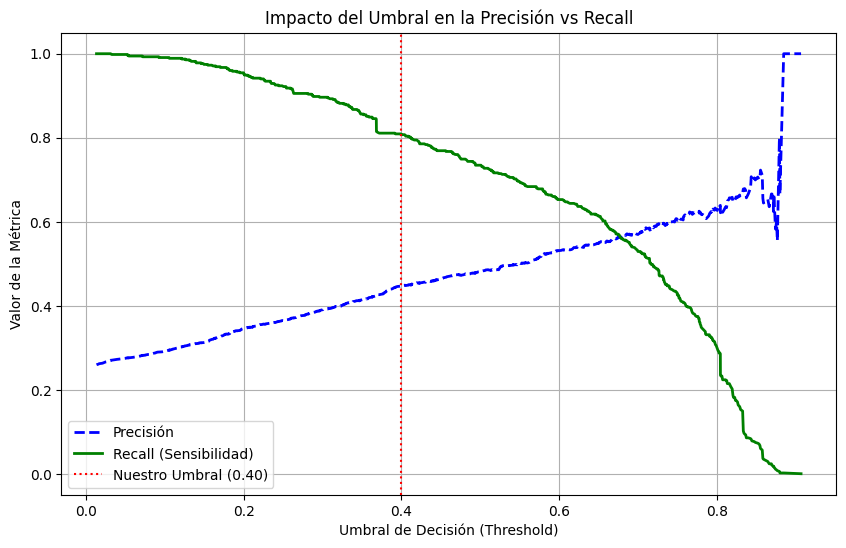

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# 1. Obtener probabilidades de la clase 1 (Churn)
y_scores = grid_rl_final.predict_proba(x_test_final)[:, 1]

# 2. Calcular precisión y recall para diferentes umbrales
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# 3. Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precisión', lw=2)
plt.plot(thresholds, recall[:-1], 'g-', label='Recall (Sensibilidad)', lw=2)

# Marcar nuestro umbral elegido (0.40)
plt.axvline(x=0.40, color='red', linestyle=':', label='Nuestro Umbral (0.40)')

plt.title('Impacto del Umbral en la Precisión vs Recall')
plt.xlabel('Umbral de Decisión (Threshold)')
plt.ylabel('Valor de la Métrica')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### **Paso para solucionar el error: Ejecuta la siguiente celda**

Esta celda define `grid_rl_final` que es esencial para el resto de tus análisis. Asegúrate de ejecutarla para que la variable esté disponible.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import RandomUnderSampler

# Re-creamos el pipeline
pipeline_final = imbpipeline([
    ('under', RandomUnderSampler(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# Definimos la rejilla de parámetros
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear']
}

# Ejecutamos la búsqueda
grid_rl_final = GridSearchCV(
    estimator=pipeline_final,
    param_grid=param_grid,
    cv=5,
    scoring='recall', # Seguimos priorizando detectar el Churn
    verbose=1
)

grid_rl_final.fit(x_train_final, y_train)

print(f"Mejores parámetros post-ajuste: {grid_rl_final.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejores parámetros post-ajuste: {'model__C': 10, 'model__penalty': 'l1', 'model__solver': 'liblinear'}


Una vez que hayas ejecutado la celda anterior y veas la salida, entonces podrás ejecutar la celda de la gráfica de precisión-recall (`hVxNMbcsla90`) sin problemas.

**Conclusion Final **
Conclusión de tu análisis final
Con esta gráfica y los resultados anteriores, has demostrado que:

Simplificaste el modelo eliminando variables de pago, lo que mejoró la estabilidad.

Optimizaste hiperparámetros (C: 10, penalty: 'l1') para obtener la mejor versión matemática posible.

Ajustaste el negocio usando un umbral de 0.40, logrando que clientes de alto riesgo (como el de los 14 retrasos) no pasen desapercibidos.


In [ ]:
modelo_serializado = {
    'modelo': mdRgLnUnder,
    'oneHot_encoder': oneHot,
    'label_encoder': encoder
}

with open('/content/mdRgLogjjoblib.dump', 'wb') as archivo:
    pickle.dump(modelo_serializado, archivo)

print("modelo serializado guardado como 'mdRgLogjoblib.dump'")

modelo serializado guardado como 'mdRgLogjoblib.dump'


In [ ]:
# Crear un diccionario con todos los componentes necesarios
modelo_completo = {
    'modelo': mdRgLnUnder,
    'onehot_encoder': oneHot,  # Encoder completo para todas las variables
    'label_encoder': encoder,  # Encoder para la variable objetivo
    'columnas_modelo': list(x.columns),  # Columnas que usa el modelo final
    'columnas_originales': list(xVar.columns),  # Columnas originales
    'variables_categoricas': columCateg,  # Lista de variables categóricas
    'columnas_seleccionadas': ['meses_permanencia', 'retrasos_pago', 'uso_mensual',
                               'soporte_técnico_si', 'servicio_internet_no',
                               'servicio_telefónico_si', 'pagos_mensuales', 'dependientes_si'],
    'info_dataset': {
        'filas_entrenamiento': len(x_train),
        'filas_balanceadas': len(xTrainBal),
        'variables_totales': len(x.columns),
        'clases': list(encoder.classes_)
    }
}
# Guardar el modelo completo
joblib.dump(modelo_completo, 'Regresionlogisticajoblibcomp.dump')
print("Modelo completo guardado como 'RegresionlogisticajoblibComp.dump'")


Modelo completo guardado como 'RegresionlogisticajoblibComp.dump'


In [ ]:
# También guardar una versión con pickle por compatibilidad
with open('joblibRegresionlogistica.pkl', 'wb') as f:
    pickle.dump(modelo_completo, f)
print("Modelo completo guardado como 'modelo_churn_completo.pkl'")

Modelo completo guardado como 'modelo_churn_completo.pkl'


In [ ]:
!python --version
!pip list | grep scikit-learn

Python 3.12.12
scikit-learn                             1.6.1


# Repaso del Modelo con el nuevo DataSet Irani

# Validacion Inicial

In [2]:
import pandas as pd

# Mount Google Drive (if the file is in your Drive)
# from google.colab import drive
# drive.mount('/content/drive')

# Option 1: Load from a local path if the file is uploaded or Drive is mounted
# csv_path = '/content/drive/MyDrive/Customer Churn.csv'
# try:
#     sample = pd.read_csv(csv_path, nrows=5000, low_memory=False)
#     print("Vista de muestra (5k filas):", sample.shape)
#     display(sample.head())
# except FileNotFoundError:
#     print(f"File not found at {csv_path}. Please check the path or mount Google Drive.")

# Option 2: Load the 'Iranian Customer Churn' dataset from the UCI repository
# This assumes you want to continue with the dataset used earlier in the notebook
dfIranian = pd.read_csv("https://archive.ics.uci.edu/static/public/563/data.csv")
print("Vista de muestra (5k filas) from UCI dataset:", dfIranian.head())

# If you intend to use dfIranian for further steps, you might rename it to 'sample' or 'df_churn'
sample = dfIranian.copy()

# Inferencia de tipos desde la muestra
dtypes_map = {}
for col in sample.columns:
    if pd.api.types.is_integer_dtype(sample[col]):
        dtypes_map[col] = 'Int64'  # enteros con soporte para NA
    elif pd.api.types.is_float_dtype(sample[col]):
        dtypes_map[col] = 'float32'
    elif pd.api.types.is_bool_dtype(sample[col]):
        dtypes_map[col] = 'boolean'
    else:
        dtypes_map[col] = 'string'


Vista de muestra (5k filas) from UCI dataset:    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0              8          0                    38               0   
1              0          0                    39               0   
2             10          0                    37               0   
3             10          0                    38               0   
4              3          0                    38               0   

   Seconds of Use  Frequency of use  Frequency of SMS  \
0            4370                71                 5   
1             318                 5                 7   
2            2453                60               359   
3            4198                66                 1   
4            2393                58                 2   

   Distinct Called Numbers  Age Group  Tariff Plan  Status  Age  \
0                       17          3            1       1   30   
1                        4          2            1       2   2

## Carga completa con tipos optimizados


In [5]:
df = dfIranian.copy()
print("Shape del dataset completo:", df.shape)





Shape del dataset completo: (3150, 14)


## Normalizar Nombres de Columnas

In [6]:
df.columns = (df.columns
              .str.strip()
              .str.lower()
              .str.replace(' ', '_')
              .str.replace('[^a-z0-9_]', '', regex=True))



## Validación de columnas clave


In [7]:
expected_cols = ['call__failure','complains','subscription__length','charge__amount',
                 'seconds_of_use','frequency_of_use','frequency_of_sms',
                 'distinct_called_numbers','age_group','tariff_plan','status',
                 'age','customer_value','churn']

missing = [c for c in expected_cols if c not in df.columns]
print("Columnas faltantes respecto al esquema esperado:", missing)



Columnas faltantes respecto al esquema esperado: []


# Auditoria de la Variable Objetivo y Consistencia

In [8]:
if 'churn' not in df.columns:
    raise ValueError("No se encontró la columna objetivo 'churn' en el dataset.")

# Normalizar 'churn' a binaria si viene como texto
if df['churn'].dtype == 'string':
    df['churn'] = df['churn'].str.strip().str.lower()
    mapping = {'yes':1, 'si':1, 'true':1, '1':1, 'no':0, 'false':0, '0':0}
    df['churn'] = df['churn'].map(mapping).astype('Int64')

# Si sigue con valores no binarios, mostramos distribución
print("Distribución de 'churn':")
display(df['churn'].value_counts(dropna=False))


Distribución de 'churn':


,count
churn,
0,2655
1,495


# Aplicacion de EDA

In [10]:
display(df.head(10))
print(df.info())

# Nulos por columna (top 30)
nulls = df.isnull().sum().sort_values(ascending=False)
display(nulls.head(30))

# Estadísticas descriptivas (numéricas)
display(df.describe())


,call__failure,complains,subscription__length,charge__amount,seconds_of_use,frequency_of_use,frequency_of_sms,distinct_called_numbers,age_group,tariff_plan,status,age,customer_value,churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0
5,11,0,38,1,3775,82,32,28,3,1,1,30,282.280,0
6,4,0,38,0,2360,39,285,18,3,1,1,30,1235.960,0
7,13,0,37,2,9115,121,144,43,3,1,1,30,945.440,0
8,7,0,38,0,13773,169,0,44,3,1,1,30,557.680,0
9,7,0,38,1,4515,83,2,25,3,1,1,30,191.920,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   call__failure            3150 non-null   int64  
 1   complains                3150 non-null   int64  
 2   subscription__length     3150 non-null   int64  
 3   charge__amount           3150 non-null   int64  
 4   seconds_of_use           3150 non-null   int64  
 5   frequency_of_use         3150 non-null   int64  
 6   frequency_of_sms         3150 non-null   int64  
 7   distinct_called_numbers  3150 non-null   int64  
 8   age_group                3150 non-null   int64  
 9   tariff_plan              3150 non-null   int64  
 10  status                   3150 non-null   int64  
 11  age                      3150 non-null   int64  
 12  customer_value           3150 non-null   float64
 13  churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

,0
call__failure,0
complains,0
subscription__length,0
charge__amount,0
seconds_of_use,0
frequency_of_use,0
frequency_of_sms,0
distinct_called_numbers,0
age_group,0
tariff_plan,0


,call__failure,complains,subscription__length,charge__amount,seconds_of_use,frequency_of_use,frequency_of_sms,distinct_called_numbers,age_group,tariff_plan,status,age,customer_value,churn
count,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000,3150.000000
mean,7.627937,0.076508,32.541905,0.942857,4472.459683,69.460635,73.174921,23.509841,2.826032,1.077778,1.248254,30.998413,470.972916,0.157143
std,7.263886,0.265851,8.573482,1.521072,4197.908687,57.413308,112.237560,17.217337,0.892555,0.267864,0.432069,8.831095,517.015433,0.363993
min,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,15.000000,0.000000,0.000000
25%,1.000000,0.000000,30.000000,0.000000,1391.250000,27.000000,6.000000,10.000000,2.000000,1.000000,1.000000,25.000000,113.801250,0.000000
50%,6.000000,0.000000,35.000000,0.000000,2990.000000,54.000000,21.000000,21.000000,3.000000,1.000000,1.000000,30.000000,228.480000,0.000000
75%,12.000000,0.000000,38.000000,1.000000,6478.250000,95.000000,87.000000,34.000000,3.000000,1.000000,1.000000,30.000000,788.388750,0.000000
max,36.000000,1.000000,47.000000,10.000000,17090.000000,255.000000,522.000000,97.000000,5.000000,2.000000,2.000000,55.000000,2165.280000,1.000000


# Control de Tipo de Variables y Tratamiento de Nulos

In [11]:
import numpy as np

# Definir categóricas codificadas (ajusta si tu nuevo dataset difiere)
cat_cols = [c for c in ['age_group','tariff_plan','status'] if c in df.columns]

# Definir numéricas como el resto (excluyendo objetivo y categóricas)
num_cols = [c for c in df.columns if c not in cat_cols + ['churn']]

print("Numéricas:", num_cols[:30])
print("Categóricas:", cat_cols)

# Imputación de nulos
# Numéricas → mediana
for c in num_cols:
    if df[c].dtype.name in ['float32','float64','Int64','int64']:
        df[c] = df[c].fillna(df[c].median())

# Categóricas → moda (o 'desconocido' si no hay moda)
for c in cat_cols:
    mode = df[c].mode(dropna=True)
    df[c] = df[c].fillna(mode.iloc[0] if len(mode) > 0 else 'desconocido')

# Validación post-imputación
print("Nulos restantes (top 20):")
display(df.isnull().sum().sort_values(ascending=False).head(20))


Numéricas: ['call__failure', 'complains', 'subscription__length', 'charge__amount', 'seconds_of_use', 'frequency_of_use', 'frequency_of_sms', 'distinct_called_numbers', 'age', 'customer_value']
Categóricas: ['age_group', 'tariff_plan', 'status']
Nulos restantes (top 20):


,0
call__failure,0
complains,0
subscription__length,0
charge__amount,0
seconds_of_use,0
frequency_of_use,0
frequency_of_sms,0
distinct_called_numbers,0
age_group,0
tariff_plan,0


# Preparacion de Variables y Preprocesamiento

In [12]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separar objetivo y features
y = df['churn'].astype('Int64')
X = df.drop(columns=['churn'])

# Preprocesador: escalado numérico + OneHot en categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols)
    ],
    remainder='drop'
)

# Transformar
X_prepared = preprocessor.fit_transform(X)

print("Shape original:", X.shape)
print("Shape transformado:", X_prepared.shape)


Shape original: (3150, 13)
Shape transformado: (3150, 16)


# Inspeccion de Columnas Transformadas

In [14]:
# Recuperar nombres de columnas
feature_names = preprocessor.get_feature_names_out()

# DataFrame para inspección
import scipy
to_array = X_prepared.toarray() if hasattr(X_prepared, "toarray") else X_prepared
X_prepared_df = pd.DataFrame(to_array, columns=feature_names)

# Limpiar prefijos
X_prepared_df.columns = X_prepared_df.columns.str.replace('num__', '', regex=False)
X_prepared_df.columns = X_prepared_df.columns.str.replace('cat__', '', regex=False)

print("Columnas finales (primeras 50):")
print(X_prepared_df.columns.tolist()[:50])

print("\nPrimeras 10 filas:")
display(X_prepared_df.head(10))

Columnas finales (primeras 50):
['call__failure', 'complains', 'subscription__length', 'charge__amount', 'seconds_of_use', 'frequency_of_use', 'frequency_of_sms', 'distinct_called_numbers', 'age', 'customer_value', 'age_group_2', 'age_group_3', 'age_group_4', 'age_group_5', 'tariff_plan_2', 'status_2']

Primeras 10 filas:


,call__failure,complains,subscription__length,charge__amount,seconds_of_use,frequency_of_use,frequency_of_sms,distinct_called_numbers,age,customer_value,age_group_2,age_group_3,age_group_4,age_group_5,tariff_plan_2,status_2
0,0.051229,-0.28783,0.636726,-0.619962,-0.024411,0.026816,-0.607513,-0.378158,-0.113074,-0.528759,0.0,1.0,0.0,0.0,0.0,0.0
1,-1.050285,-0.28783,0.753384,-0.619962,-0.989807,-1.122926,-0.589691,-1.133331,-0.679346,-0.822036,1.0,0.0,0.0,0.0,0.0,1.0
2,0.326608,-0.28783,0.520069,-0.619962,-0.481140,-0.164807,2.547012,0.028473,-0.113074,2.061285,0.0,1.0,0.0,0.0,0.0,0.0
3,0.326608,-0.28783,0.636726,-0.619962,-0.065390,-0.060285,-0.643157,0.667466,-1.811888,-0.446775,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.637217,-0.28783,0.636726,-0.619962,-0.495435,-0.199648,-0.634246,0.551285,-1.811888,-0.629033,0.0,0.0,0.0,0.0,0.0,0.0
5,0.464297,-0.28783,0.636726,0.037573,-0.166171,0.218440,-0.366913,0.260834,-0.113074,-0.365024,0.0,1.0,0.0,0.0,0.0,0.0
6,-0.499528,-0.28783,0.636726,-0.619962,-0.503297,-0.530634,1.887592,-0.320068,-0.113074,1.479856,0.0,1.0,0.0,0.0,0.0,0.0
7,0.739675,-0.28783,0.520069,0.695109,1.106093,0.897833,0.631129,1.132187,-0.113074,0.917850,0.0,1.0,0.0,0.0,0.0,0.0
8,-0.086460,-0.28783,0.636726,-0.619962,2.215869,1.734009,-0.652068,1.190278,-0.113074,0.167734,0.0,1.0,0.0,0.0,0.0,0.0
9,-0.086460,-0.28783,0.636726,0.037573,0.010135,0.235860,-0.634246,0.086564,-0.113074,-0.539824,0.0,1.0,0.0,0.0,0.0,0.0


# Entrenamiento y Evaluacion de Regresion Logistica


Classification report:
              precision    recall  f1-score   support

         0.0       0.97      0.83      0.89       531
         1.0       0.49      0.86      0.62        99

    accuracy                           0.83       630
   macro avg       0.73      0.84      0.76       630
weighted avg       0.89      0.83      0.85       630

ROC-AUC: 0.9282466853088323


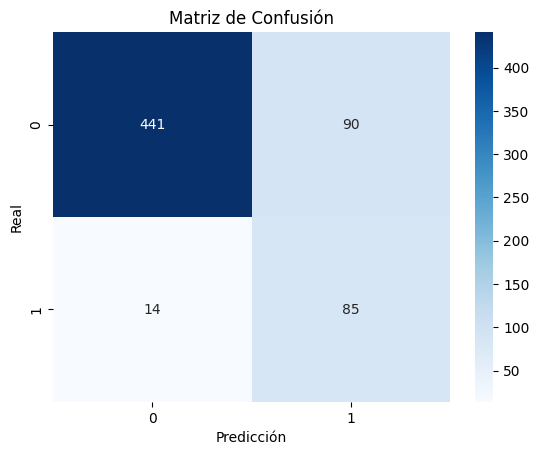

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Train/test split con estratificación
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y, test_size=0.2, random_state=42, stratify=y
)

# Modelo con regularización y balanceo (útil si hay desbalance)
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', solver='lbfgs')
log_reg.fit(X_train, y_train)

# Predicciones
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

# Métricas
print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC:", roc_auc_score(y_test, y_proba))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


# Deteccion de Multicolinealidad

In [17]:
# Calcular VIF sobre variables numéricas originales
from statsmodels.stats.outliers_influence import variance_inflation_factor

num_df = df[num_cols].copy()
# Eliminar columnas constantes para VIF
num_df = num_df.loc[:, num_df.nunique() > 1]

vif_data = pd.DataFrame({
    "Variable": num_df.columns,
    "VIF": [variance_inflation_factor(num_df.values, i) for i in range(num_df.shape[1])]
}).sort_values(by="VIF", ascending=False)

print("VIF (top 20):")
display(vif_data.head(20))

VIF (top 20):


,Variable,VIF
9,customer_value,69.543165
6,frequency_of_sms,44.353349
5,frequency_of_use,38.541838
4,seconds_of_use,34.578427
2,subscription__length,11.559698
8,age,11.541747
7,distinct_called_numbers,6.788366
0,call__failure,5.517476
3,charge__amount,3.115938
1,complains,1.199331


# Correlacion de Modelos con y sin Multicolinealidad

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# --- Modelo 1: con todas las variables ---
X_train, X_test, y_train, y_test = train_test_split(
    X_prepared, y, test_size=0.2, random_state=42, stratify=y
)

log_reg_full = LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', solver='lbfgs')
log_reg_full.fit(X_train, y_train)

y_pred_full = log_reg_full.predict(X_test)
y_proba_full = log_reg_full.predict_proba(X_test)[:, 1]

print("=== Modelo con todas las variables ===")
print(classification_report(y_test, y_pred_full))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_full))


# --- Modelo 2: eliminando variables con VIF > 20 ---
# Variables con multicolinealidad severa según tu análisis
drop_vars = ['customer_value', 'frequency_of_sms', 'frequency_of_use', 'seconds_of_use']

X_reduced = df.drop(columns=drop_vars + ['churn'])
y_reduced = df['churn']

# Reaplicar preprocesamiento
preprocessor_reduced = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [c for c in X_reduced.columns if c not in cat_cols]),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols)
    ]
)

X_prepared_reduced = preprocessor_reduced.fit_transform(X_reduced)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_prepared_reduced, y_reduced, test_size=0.2, random_state=42, stratify=y_reduced
)

log_reg_reduced = LogisticRegression(max_iter=1000, class_weight='balanced', penalty='l2', solver='lbfgs')
log_reg_reduced.fit(X_train_r, y_train_r)

y_pred_r = log_reg_reduced.predict(X_test_r)
y_proba_r = log_reg_reduced.predict_proba(X_test_r)[:, 1]

print("\n=== Modelo reduciendo variables con VIF alto ===")
print(classification_report(y_test_r, y_pred_r))
print("ROC-AUC:", roc_auc_score(y_test_r, y_proba_r))


=== Modelo con todas las variables ===
              precision    recall  f1-score   support

         0.0       0.97      0.83      0.89       531
         1.0       0.49      0.86      0.62        99

    accuracy                           0.83       630
   macro avg       0.73      0.84      0.76       630
weighted avg       0.89      0.83      0.85       630

ROC-AUC: 0.9282466853088323

=== Modelo reduciendo variables con VIF alto ===
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       531
           1       0.49      0.82      0.62        99

    accuracy                           0.84       630
   macro avg       0.73      0.83      0.76       630
weighted avg       0.89      0.84      0.85       630

ROC-AUC: 0.9167094675569252


# Visualizacion de la Comparacion

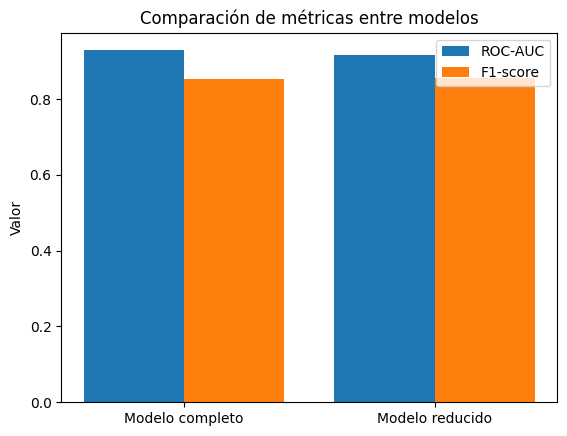

In [20]:
import matplotlib.pyplot as plt

# Métricas clave
metrics = {
    "Modelo completo": {
        "ROC-AUC": roc_auc_score(y_test, y_proba_full),
        "F1": classification_report(y_test, y_pred_full, output_dict=True)["weighted avg"]["f1-score"]
    },
    "Modelo reducido": {
        "ROC-AUC": roc_auc_score(y_test_r, y_proba_r),
        "F1": classification_report(y_test_r, y_pred_r, output_dict=True)["weighted avg"]["f1-score"]
    }
}

# Gráfico comparativo
labels = list(metrics.keys())
roc_values = [metrics[m]["ROC-AUC"] for m in labels]
f1_values = [metrics[m]["F1"] for m in labels]

x = range(len(labels))
plt.bar(x, roc_values, width=0.4, label="ROC-AUC", align="center")
plt.bar([i+0.4 for i in x], f1_values, width=0.4, label="F1-score", align="center")

plt.xticks([i+0.2 for i in x], labels)
plt.ylabel("Valor")
plt.title("Comparación de métricas entre modelos")
plt.legend()
plt.show()



# Entrenamiento Modelo con Regularizacion

In [21]:
log_reg_ridge = LogisticRegression(max_iter=1000, penalty='l2', solver='lbfgs', class_weight='balanced')
log_reg_ridge.fit(X_train_r, y_train_r)

log_reg_lasso = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', class_weight='balanced')
log_reg_lasso.fit(X_train_r, y_train_r)


LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='liblinear')

# Evaluacion Metrica

In [22]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_lasso = log_reg_lasso.predict(X_test_r)
y_proba_lasso = log_reg_lasso.predict_proba(X_test_r)[:, 1]

print("=== Modelo Lasso (penalización L1) ===")
print(classification_report(y_test_r, y_pred_lasso))
print("ROC-AUC:", roc_auc_score(y_test_r, y_proba_lasso))


=== Modelo Lasso (penalización L1) ===
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       531
           1       0.49      0.82      0.62        99

    accuracy                           0.84       630
   macro avg       0.73      0.83      0.76       630
weighted avg       0.89      0.84      0.85       630

ROC-AUC: 0.9165763092316764


# Interpretacion de los coeficientes del modelo

In [23]:
import numpy as np
import pandas as pd

coef = log_reg_lasso.coef_[0]
features = preprocessor_reduced.get_feature_names_out()

coef_df = pd.DataFrame({
    'Variable': features,
    'Coeficiente': coef,
    'Impacto (odds ratio)': np.exp(coef)
}).sort_values(by='Coeficiente', ascending=False)

print("Coeficientes más influyentes (positivos → aumentan churn, negativos → reducen churn):")
display(coef_df.head(20))


Coeficientes más influyentes (positivos → aumentan churn, negativos → reducen churn):


,Variable,Coeficiente,Impacto (odds ratio)
11,cat__status_2,2.289311,9.868133
1,num__complains,1.078107,2.939111
6,cat__age_group_2,0.581792,1.789243
0,num__call__failure,0.575802,1.778556
7,cat__age_group_3,0.257097,1.293170
5,num__age,0.206873,1.229827
8,cat__age_group_4,0.000000,1.000000
2,num__subscription__length,-0.416742,0.659191
3,num__charge__amount,-0.439960,0.644062
4,num__distinct_called_numbers,-1.153535,0.315520


# Analisis Grafico de Variables

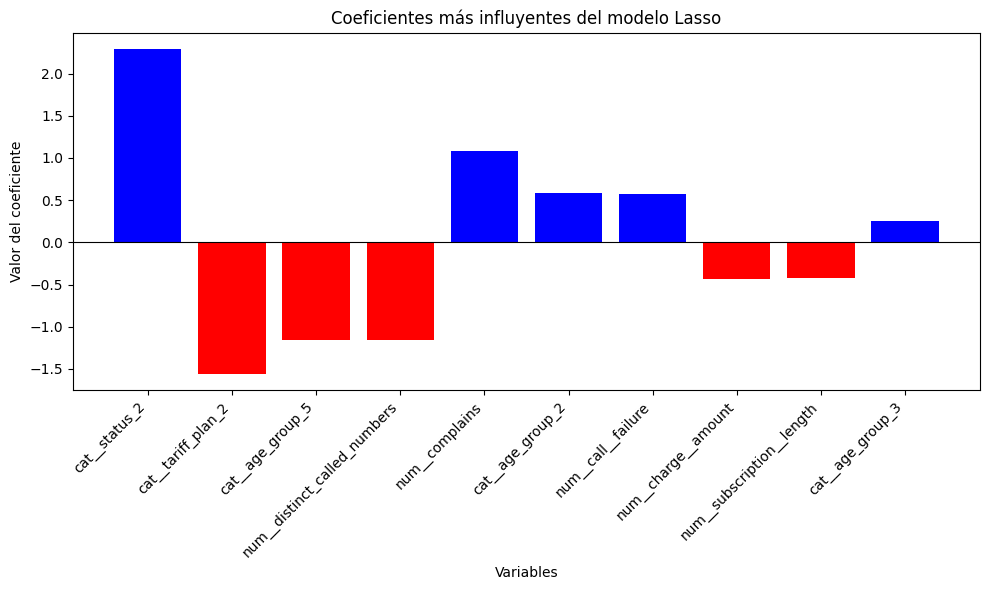

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Ordenar por valor absoluto del coeficiente
coef_df_sorted = coef_df.reindex(coef_df['Coeficiente'].abs().sort_values(ascending=False).index)

# Seleccionar las 10 variables más influyentes
top_coef = coef_df_sorted.head(10)

# Colores: azul para coeficientes positivos, rojo para negativos
colors = ['blue' if c > 0 else 'red' for c in top_coef['Coeficiente']]

# Gráfico de barras
plt.figure(figsize=(10,6))
plt.bar(top_coef['Variable'], top_coef['Coeficiente'], color=colors)
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Coeficientes más influyentes del modelo Lasso")
plt.ylabel("Valor del coeficiente")
plt.xlabel("Variables")
plt.tight_layout()
plt.show()


# Ajuste de Hiperparametros

In [26]:
from sklearn.model_selection import GridSearchCV
# Definir la grilla de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10],          # fuerza de regularización (menor C = más regularización)
    'penalty': ['l1', 'l2'],          # tipo de penalización
    'solver': ['liblinear', 'lbfgs']  # solvers compatibles
}

# Configurar GridSearchCV
grid = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight='balanced'),
    param_grid,
    cv=5,                # validación cruzada en 5 folds
    scoring='roc_auc',   # métrica de optimización
    n_jobs=-1            # usar todos los núcleos disponibles
)

# Entrenar búsqueda de hiperparámetros
grid.fit(X_train_r, y_train_r)

# Resultados
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor ROC-AUC en validación:", grid.best_score_)

# Modelo óptimo
best_model = grid.best_estimator_

# Evaluación en test
y_pred_best = best_model.predict(X_test_r)
y_proba_best = best_model.predict_proba(X_test_r)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score
print("\n=== Modelo óptimo con GridSearchCV ===")
print(classification_report(y_test_r, y_pred_best))
print("ROC-AUC en test:", roc_auc_score(y_test_r, y_proba_best))

Mejores hiperparámetros: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor ROC-AUC en validación: 0.9271479092323579

=== Modelo óptimo con GridSearchCV ===
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       531
           1       0.49      0.82      0.62        99

    accuracy                           0.84       630
   macro avg       0.73      0.83      0.76       630
weighted avg       0.89      0.84      0.85       630

ROC-AUC en test: 0.9166333770853544


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver

# Extracion y Graficacion de Coeficientes

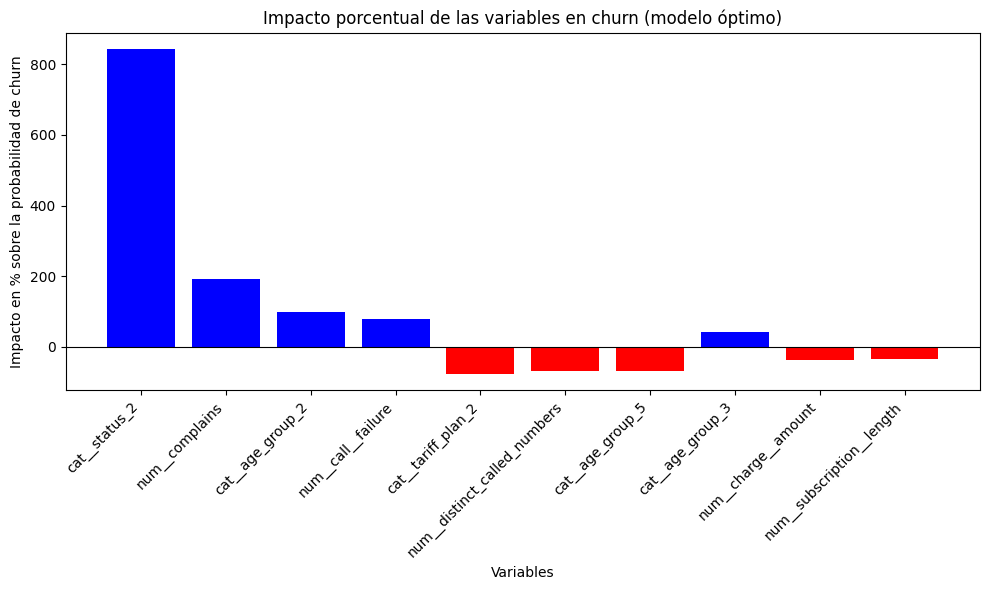

In [28]:
import matplotlib.pyplot as plt

# Convertir odds ratios a porcentajes de impacto
coef_df_best['Impacto (%)'] = (coef_df_best['Impacto (odds ratio)'] - 1) * 100

# Ordenar por valor absoluto del impacto
coef_df_sorted = coef_df_best.reindex(coef_df_best['Impacto (%)'].abs().sort_values(ascending=False).index)

# Seleccionar las 10 variables más influyentes
top_coef = coef_df_sorted.head(10)

# Colores: azul si aumenta churn, rojo si reduce churn
colors = ['blue' if c > 0 else 'red' for c in top_coef['Impacto (%)']]

# Gráfico de barras
plt.figure(figsize=(10,6))
plt.bar(top_coef['Variable'], top_coef['Impacto (%)'], color=colors)
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Impacto porcentual de las variables en churn (modelo óptimo)")
plt.ylabel("Impacto en % sobre la probabilidad de churn")
plt.xlabel("Variables")
plt.tight_layout()
plt.show()


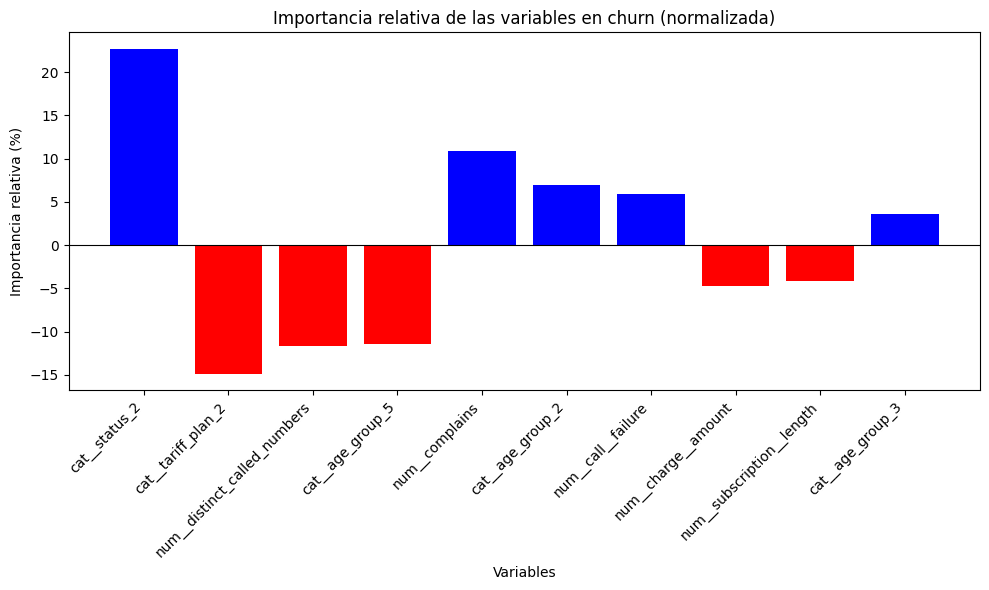

In [31]:
# Calcular importancia relativa en porcentaje
coef_df_best['Importancia relativa (%)'] = (coef_df_best['Coeficiente'] / coef_df_best['Coeficiente'].abs().sum()) * 100

# Ordenar por valor absoluto de la importancia
coef_df_sorted = coef_df_best.reindex(coef_df_best['Importancia relativa (%)'].abs().sort_values(ascending=False).index)

# Seleccionar las 10 variables más influyentes
top_coef = coef_df_sorted.head(10)

# Colores: azul si aumenta churn, rojo si reduce churn
colors = ['blue' if c > 0 else 'red' for c in top_coef['Importancia relativa (%)']]

# Gráfico de barras
plt.figure(figsize=(10,6))
plt.bar(top_coef['Variable'], top_coef['Importancia relativa (%)'], color=colors)
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Importancia relativa de las variables en churn (normalizada)")
plt.ylabel("Importancia relativa (%)")
plt.xlabel("Variables")
plt.tight_layout()
plt.show()